In [47]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, modified_precision
from nltk.metrics import scores
import scipy.io.wavfile
from IPython.display import Audio
from IPython.display import display
from nltk.stem import *
# from nltk.stem.snowball import SnowballStemmer
from stemming.porter2 import stem
import stemming

%matplotlib inline

In [2]:
from nmt_run import *

  0%|          | 0/3959 [00:00<?, ?it/s]

fisher + callhome sp/es - en configuration
--------------------------------------------------
loading info_dict from=./callhome_fbank_out/info.dict
--------------------------------------------------
creating buckets for: fisher_dev
creating buckets for key: sp
creating buckets for: fisher_dev2
creating buckets for key: sp


 44%|████▍     | 61486/138708 [00:00<00:00, 614853.26it/s]

creating buckets for: fisher_test
creating buckets for key: sp
creating buckets for: fisher_train
creating buckets for key: sp


100%|██████████| 14284/14284 [00:00<00:00, 631404.40it/s]


creating buckets for: callhome_devtest
creating buckets for key: sp
creating buckets for: callhome_evltest
creating buckets for key: sp
creating buckets for: callhome_train
creating buckets for key: sp
--------------------------------------------------
saving info dict in: ./callhome_fbank_out/buckets_sp.dict
all done ...
--------------------------------------------------
showing buckets for category: fisher_dev
number of buckets=8, width of each bucket=256
index | width | num   
    0 |     0 |   1804
    1 |   256 |   1047
    2 |   512 |    559
    3 |   768 |    348
    4 |  1024 |    158
    5 |  1280 |     53
    6 |  1536 |      6
    7 |  1792 |      2
--------------------------------------------------
showing buckets for category: fisher_dev2
number of buckets=8, width of each bucket=256
index | width | num   
    0 |     0 |   1656
    1 |   256 |   1177
    2 |   512 |    546
    3 |   768 |    363
    4 |  1024 |    150
    5 |  1280 |     50
    6 |  1536 |     16
    7 | 

/afs/inf.ed.ac.uk/group/project/lowres/work/anaconda3/envs/chainer2/lib/python3.6/site-packages/chainer/utils/experimental.py:104: FutureWarning: chainer.links.normalization.layer_normalization.py is experimental. The interface can change in the future.
  FutureWarning)


using ADAM optimizer


In [3]:
model_files = [f for f in os.listdir(os.path.dirname(model_fil))
                   if os.path.basename(model_fil).replace('.model','') in f]
# print(model_files)

In [4]:
max_model_fil = max(model_files, key=lambda s: int(s.split('_')[-1].split('.')[0]))

In [5]:
max_model_fil

'seq2seq_sen-138819_hwy0-dec4_emb-256-h-256__sp_en_w_gru_drpt-0.3_noise-0_l2-0.000100_32_32_2_2_2DCNN_BN_LN_enc-4_151.model'

In [6]:
last_epoch = check_model()

--------------------------------------------------------------------------------
model found = 
fsh_fbank/seq2seq_sen-138819_hwy0-dec4_emb-256-h-256__sp_en_w_gru_drpt-0.3_noise-0_l2-0.000100_32_32_2_2_2DCNN_BN_LN_enc-4_151.model
loading ...
finished loading ..


In [7]:
log_dev_fil_name

'fsh_fbank/dev_sen-138819_hwy0-dec4_emb-256-h-256__sp_en_w_gru_drpt-0.3_noise-0_l2-0.000100_32_32_2_2_2DCNN_BN_LN_enc-4.log'

In [14]:
log_train = np.loadtxt(log_train_fil_name, delimiter=',', skiprows=False).transpose()
log_test = np.genfromtxt(log_dev_fil_name, delimiter=',', usecols = (0,1,2)).transpose()

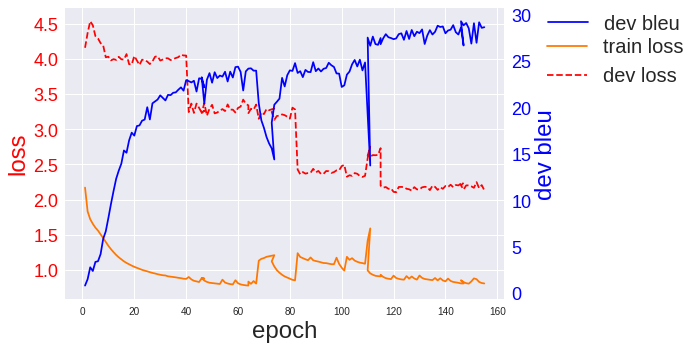

In [15]:
fig, ax1 = plt.subplots()
fig.set_size_inches(8,5)
ax1.plot(log_train[0], log_train[1], color='#ff7700')
ax1.plot(log_test[0], log_test[1], 'r--')
ax1.set_xlabel('epoch', size=24)
ax1.set_ylabel('loss', color='r', size=24)
for tl in ax1.get_yticklabels():
    tl.set_color('r')
    tl.set_fontsize(18)
plt.legend(['train loss', 'dev loss'], bbox_to_anchor=(1.45, 0.96), framealpha=0, fontsize=20)    
ax2 = ax1.twinx()
ax2.plot(log_test[0], log_test[2]*100, 'b-')
ax2.set_xlabel('iteration')
ax2.set_ylabel('dev bleu', color='b', size=24)
# ax1.set_xlim(0, 60)
for tl in ax2.get_yticklabels():
    tl.set_color('b')
    tl.set_fontsize(18) 
plt.legend(['dev bleu'], bbox_to_anchor=(1.44, 1.04), framealpha=0, fontsize=20)
# plt.legend(['dev bleu'], bbox_to_anchor=(1.06, 0.9), framealpha=0, fontsize=20)
plt.grid(False)
plt.tight_layout()

In [16]:
import nltk.translate.bleu_score

In [17]:
def play_utt(utt, m_dict):
    sr, y = scipy.io.wavfile.read(os.path.join(wavs_path, utt.rsplit("-",1)[0]+'.wav'))
    start_t = min(seg['start'] for seg in m_dict[utt]['seg'])
    end_t = max(seg['end'] for seg in m_dict[utt]['seg'])
    print(start_t, end_t)
    start_t_samples, end_t_samples = int(start_t*sr), int(end_t*sr)
    display(Audio(y[start_t_samples:end_t_samples], rate=sr))

In [18]:
def display_words(m_dict, v_dict, preds, utts, dec_key, key, min_len=0, max_len=MAX_EN_LEN, play_audio=False):
    es_ref = []
    en_ref = []
    for u in utts:
        es_ref.append(" ".join([w.decode() for w in m_dict[u]['es_w']]))
        if type(m_dict[u][dec_key]) == list:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w']]))
        else:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w'][0]]))

    en_pred = []
    join_str = ' ' if dec_key.endswith('_w') else ''

    for p in preds:
        t_str = join_str.join([v_dict['i2w'][i].decode() for i in p])
        t_str = t_str[:t_str.find('_EOS')]
        en_pred.append(t_str)

    for u, es, en, p in zip(utts, es_ref, en_ref, en_pred):
        if len(en.split(" ")) >= min_len and len(en.split(" ")) <= max_len:
            # for reference, 1st word is GO_ID, no need to display
            print("Utterance: {0:s}".format(u))
            display_pp = PrettyTable(["cat","sent"], hrules=True)
            display_pp.align = "l"
            display_pp.header = False
            display_pp.add_row(["es ref", textwrap.fill(es,50)])
            display_pp.add_row(["en ref", textwrap.fill(en,50)])
            display_pp.add_row(["en pred", textwrap.fill(p,50)])

            print(display_pp)
            if play_audio:
                play_utt(u, m_dict)
    

In [19]:
def display_words_latex(m_dict, v_dict, preds, utts, dec_key, min_len=0, max_len=2*MAX_EN_LEN):
    print("min length={0:d}, max length={1:d}".format(min_len, max_len))
    es_ref = []
    en_ref = []
    for u in utts:
        es_ref.append(" ".join([w.decode() for w in m_dict[u]['es_w']]))
        if type(m_dict[u][dec_key]) == list:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w']]))
        else:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w'][0]]))

    en_pred = []
    join_str = ' ' if dec_key.endswith('_w') else ''

    for p in preds:
        t_str = join_str.join([v_dict['i2w'][i].decode() for i in p])
        t_str = t_str[:t_str.find('_EOS')]
        en_pred.append(t_str)

    total_matching_len = 0

    for u, es, en, p in zip(utts, es_ref, en_ref, en_pred):
        if len(es.split(" ")) >= min_len and len(es.split(" ")) <= max_len:
            total_matching_len += 1
            # for reference, 1st word is GO_ID, no need to display
            print("Utterance: {0:s}".format(u))
            print("{0:d} & {1:s} & {2:s} & {3:s} \\\\".format(total_matching_len, es, en, p))

    print("total utts matching length filters={0:d}".format(total_matching_len))

In [54]:
def write_predictions_to_file(m_dict, v_dict, preds, utts, dec_key, key, 
                              min_len=0, max_len=2*MAX_EN_LEN, stemmify=False):
    print("min length={0:d}, max length={1:d}".format(min_len, max_len))
    en_hyp = []
    en_ref = []
    ref_key = 'en_w' if 'en_' in dec_key else 'es_w'
    src_key = 'es_w'
    
#     if stemmify:
#         stemmer = SnowballStemmer("english")
    
    for u in tqdm(utts, ncols=80):
        if len(m_dict[u][src_key]) >= min_len and len(m_dict[u][src_key]) <= max_len:
            if type(m_dict[u][ref_key]) == list:
                if stemmify:
                    en_ref.append(" ".join([stem(w.decode()) for w in m_dict[u]['en_w']]))
                else:
                    en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w']]))
            else:
                en_r_list = []
                for r in m_dict[u][ref_key]:
                    if stemmify:
                        en_r_list.append(" ".join([stem(w.decode()) for w in r]))
                    else:
                        en_r_list.append(" ".join([w.decode() for w in r]))
                en_ref.append(en_r_list)

    join_str = ' ' if dec_key.endswith('_w') else ''

    total_matching_len = 0

    for u, p in zip(utts, preds):
        if len(m_dict[u][src_key]) >= min_len and len(m_dict[u][src_key]) <= max_len:
            total_matching_len += 1
            if stemmify:
                t_str = join_str.join([stem(v_dict['i2w'][i].decode()) if i != EOS_ID else EOS.decode() for i in p])
            else:
                t_str = join_str.join([v_dict['i2w'][i].decode() for i in p])
            t_str = t_str[:t_str.find('_EOS')]
            en_hyp.append(t_str)


    print("total utts matching length filters={0:d}".format(total_matching_len))
    
    with open("{0:s}_mt-output".format(key), "w") as pred_f:
        for p in en_hyp:
            pred_f.write("{0:s}\n".format(p))
        # end for
    # end while
    
    if type(m_dict[utts[0]][ref_key]) == list:
        with open("{0:s}.ref0".format(key), "w") as ref_f:
            for r in en_ref:
                ref_f.write("{0:s}\n".format(r))
    else:
        num_ref = len(m_dict[u][ref_key])
        for i in range(num_ref):
            with open("{0:s}_en.ref{1:d}".format(key,i), "w") as ref_f:
                for r in en_ref:
                    ref_f.write("{0:s}\n".format(r[i]))
                # end for each utt
            # end with
        # end for reference
    # end else
    print("done")
    return en_ref, en_hyp

### Fisher dev

In [131]:
key='fisher_dev'
train=False
m_dict = map_dict[key]
v_dict = vocab_dict[dec_key]
n=len(map_dict[key])
BATCH_SIZE = 100

In [132]:
cat_speech_path = os.path.join(out_path, key)
wavs_path = os.path.join(out_path, "wavs")

In [133]:
print("-"*80)
print("EPOCH = {0:d}".format(last_epoch+1))
fsh_pred_sents, fsh_utts, loss = feed_model(map_dict[key],
                  b_dict=bucket_dict[key],
                  vocab_dict=vocab_dict,
                  batch_size=BATCH_SIZE,
                  x_key=enc_key,
                  y_key=dec_key,
                  train=train,
                  cat_speech_path=cat_speech_path, use_y=True)

print("{0:s} {1:s} mean loss={2:.4f}".format("*" * 10,
                                    "train" if train else "dev",
                                    loss))
print("-")
print("-"*80)

  0%|                                                  | 0/3977 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
EPOCH = 152


b=3,l=2.97,avg=2.12: 100%|██████████████████| 3977/3977 [02:51<00:00, 11.84it/s]

********** dev mean loss=2.1186
-
--------------------------------------------------------------------------------


In [134]:
# Eval parameters
ref_index = -1
min_len, max_len= 0, 200
displayN = 50

In [136]:
display_words(m_dict, v_dict, fsh_pred_sents[:displayN], fsh_utts[:displayN], 
              dec_key, key, min_len=min_len, max_len=max_len, play_audio=False)

Utterance: 20051016_210626_267_fsp-B-7
+---------+---------------+
| es ref  | aodri         |
+---------+---------------+
| en ref  | aodri         |
+---------+---------------+
| en pred | audrey audrey |
+---------+---------------+
Utterance: 20051016_180547_265_fsp-B-37
+---------+-----+
| es ref  | mmm |
+---------+-----+
| en ref  | mm  |
+---------+-----+
| en pred | mm  |
+---------+-----+
Utterance: 20051024_180453_327_fsp-B-9
+---------+-----------+
| es ref  | uhum uhum |
+---------+-----------+
| en ref  | uhum uhum |
+---------+-----------+
| en pred | hmm hmm   |
+---------+-----------+
Utterance: 20051017_220530_275_fsp-A-5
+---------+---------------------------+
| es ref  | ¿ya eres papá otra vez    |
+---------+---------------------------+
| en ref  | you are a father again    |
+---------+---------------------------+
| en pred | you already have a father |
+---------+---------------------------+
Utterance: 20051023_232057_325_fsp-A-29
+---------+-----+
| es ref  | sí 

In [137]:
os.chdir("..")
os.chdir("/afs/inf.ed.ac.uk/group/project/lowres/work/chainer2/speech2text")

In [138]:
b, _, h, r = calc_bleu(m_dict, 
                              v_dict, 
                              fsh_pred_sents, 
                              fsh_utts, 
                              dec_key, 
                              min_len=min_len, 
                              max_len=max_len, 
                              ref_index=ref_index)

print("BLEU score on: {0:s} = {1:.2f}".format(key, b * 100))
print("-"*60)

# chrf = [0]*4

# for ref_i in range(4):
#     _, chrf[ref_i], _, _ = calc_bleu(m_dict, 
#                               v_dict, 
#                               fsh_pred_sents[:n], 
#                               fsh_utts[:n], 
#                               dec_key, 
#                               min_len=min_len, 
#                               max_len=max_len, 
#                               ref_index=ref_i)
#     # end for

# # print chrf score
# for i in range(4):
#     print("CHRF score on: {0:s} = {1:.2f}, using reference = {2:d}".format(key, chrf[i] * 100, i))

# print("-"*60)

all_weights=[(1.,0.,0.,0.),
             (0.,1.,0.,0.),
             (0.,0.,1.,0.),
             (0.,0.,0.,1.),
             (1./2,1./2,0.,0.),
             (1./3,1./3,1./3,0.),
             (.25,.25,.25,.25)]

100%|████████████████████████████████████| 3977/3977 [00:00<00:00, 63362.98it/s]

min length=0, max length=200
total utts matching length filters=3977
BLEU score on: fisher_dev = 29.10
------------------------------------------------------------


In [139]:
# list(zip(h,r[:5]))

In [140]:
smooth_fun = nltk.translate.bleu_score.SmoothingFunction()

In [141]:
# print("{0:>20s} | {1:20s}".format("bleu score (0-100)", "uni-bi-tri-quad"))
# for weights in all_weights:
#     b = corpus_bleu(r, h, weights=weights, smoothing_function=smooth_fun.method2)
#     print("{0:20.2f} | {1:20s}".format(b * 100, "-".join(map("{0:.2f}".format, weights))))

In [142]:
_, _ = corpus_precision_recall(r, h)

min length=0, max length=240
total utts=3977
metric     |   1-gram |   2-gram|   3-gram |   4-gram
------------------------------------------------------
precision  |    64.51 |    37.40|    22.22 |    13.39
recall     |    62.66 |    36.27|    21.53 |    12.95


In [143]:
pred_path = "/afs/inf.ed.ac.uk/group/project/lowres/work/installs/fisher-callhome-corpus/corpus/ldc"
pred_fname = os.path.join(pred_path, "fisher_dev.pred")

In [148]:
m_dict[fsh_utts[2]]['en_w']

([b'uhum', b'uhum'],
 [b'uhum', b'uhum'],
 [b'uhum', b'uhum'],
 [b'uh', b'um', b'uh', b'um'])

In [147]:
en_ref, en_hyp = write_predictions_to_file(m_dict, v_dict, fsh_pred_sents, fsh_utts, 
                                           dec_key, key, min_len=min_len, max_len=max_len, stemmify=True)

  6%|██▎                                   | 247/3977 [00:00<00:01, 2466.53it/s]

min length=0, max length=200


100%|██████████████████████████████████████| 3977/3977 [00:04<00:00, 918.63it/s]

total utts matching length filters=3977
done


In [111]:
stem('tion')

'tion'

In [112]:
len(en_ref),len(en_hyp)

(2544, 2544)

### Callhome dev

In [149]:
key='callhome_devtest'
train=False
m_dict = map_dict[key]
v_dict = vocab_dict[dec_key]
n=len(map_dict[key])
BATCH_SIZE = 100

In [150]:
cat_speech_path = os.path.join(out_path, key)

In [117]:
print("-"*80)
print("EPOCH = {0:d}".format(last_epoch+1))
call_pred_sents, call_utts, loss = feed_model(map_dict[key],
                  b_dict=bucket_dict[key],
                  vocab_dict=vocab_dict,
                  batch_size=BATCH_SIZE,
                  x_key=enc_key,
                  y_key=dec_key,
                  train=train,
                  cat_speech_path=cat_speech_path, use_y=True)

print("{0:s} {1:s} mean loss={2:.4f}".format("*" * 10,
                                    "train" if train else "dev",
                                    loss))
print("-")
print("-"*80)

  0%|                                                  | 0/3801 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
EPOCH = 152


b=2,l=2.79,avg=2.68: 100%|██████████████████| 3801/3801 [03:14<00:00,  7.24it/s]

********** dev mean loss=2.6832
-
--------------------------------------------------------------------------------


In [118]:
display_words(m_dict, v_dict, call_pred_sents[:displayN], call_utts[:displayN],
              dec_key, key, min_len=min_len, max_len=max_len, play_audio=False)

Utterance: sp_1552-B-32
+---------+----------------------------------------------------+
| es ref  | pues este le dijo el doctor que no sabía lo que    |
|         | tenía y le mandó hacer unos estudios de excremento |
|         | pero entonces enrique se encontró en este último   |
|         | examen a un doctor que estaba ahí cuando lo operó  |
+---------+----------------------------------------------------+
| en ref  | well the doctor told him that he didn t know what  |
|         | he had and had him do some stool exams but then    |
|         | enrique ran into in this last exam with a doctor   |
|         | who was there when he operated him                 |
+---------+----------------------------------------------------+
| en pred | yes                                                |
+---------+----------------------------------------------------+
Utterance: sp_1292-B-28
+---------+----------------------------------------------------+
| es ref  | bueno así que don seso se lo i

In [152]:
b, _, h, r = calc_bleu(m_dict, 
                              v_dict, 
                              call_pred_sents, 
                              call_utts, 
                              dec_key, 
                              min_len=min_len, 
                              max_len=max_len, 
                              ref_index=ref_index)

print("BLEU score on: {0:s} = {1:.2f}".format(key, b * 100))
print("-"*60)

all_weights=[(1.,0.,0.,0.),
             (0.,1.,0.,0.),
             (0.,0.,1.,0.),
             (0.,0.,0.,1.),
             (1./2,1./2,0.,0.),
             (1./3,1./3,1./3,0.),
             (.25,.25,.25,.25)]

100%|███████████████████████████████████| 3801/3801 [00:00<00:00, 125781.47it/s]

min length=0, max length=200
total utts matching length filters=3801
BLEU score on: callhome_devtest = 5.76
------------------------------------------------------------


In [153]:
smooth_fun = nltk.translate.bleu_score.SmoothingFunction()

In [154]:
print("{0:>20s} | {1:20s}".format("bleu score (0-100)", "uni-bi-tri-quad"))
for weights in all_weights:
    b = corpus_bleu(r, h, weights=weights, smoothing_function=smooth_fun.method2)
    print("{0:20.2f} | {1:20s}".format(b * 100, "-".join(map("{0:.2f}".format, weights))))

  bleu score (0-100) | uni-bi-tri-quad     
               22.05 | 1.00-0.00-0.00-0.00 
                8.17 | 0.00-1.00-0.00-0.00 
                3.61 | 0.00-0.00-1.00-0.00 
                1.69 | 0.00-0.00-0.00-1.00 
               13.42 | 0.50-0.50-0.00-0.00 
                8.66 | 0.33-0.33-0.33-0.00 
                5.76 | 0.25-0.25-0.25-0.25 


In [155]:
_, _ = corpus_precision_recall(r, h)

min length=0, max length=240
total utts=3801
metric     |   1-gram |   2-gram|   3-gram |   4-gram
------------------------------------------------------
precision  |    36.05 |    13.36|     5.90 |     2.77
recall     |    24.17 |     9.00|     4.00 |     1.89


In [160]:
call_en_ref, call_en_hyp = write_predictions_to_file(m_dict, v_dict, call_pred_sents, call_utts, 
                                                     dec_key, key, min_len=min_len, max_len=max_len, stemmify=False)

100%|████████████████████████████████████| 3801/3801 [00:00<00:00, 95515.27it/s]

min length=0, max length=200
total utts matching length filters=3801
done


In [157]:
len(call_en_ref),len(call_en_hyp)

(3801, 3801)

### Test code

In [ ]:
# test_ref = [["ha ha lol hue".split()], ["ha ha ja ha".split()], ["ha ha ja ha".split()]]
# test_h = ["lol ja".split(), "ha he".split(), "ha ja".split()]
# _, _ = corpus_precision_recall(test_ref, test_h)